In [1]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Télécharger les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Charger les données
train_df = pd.read_csv('data/train.csv')
train_df = train_df.sample(frac=0.2, random_state=42)
game_overview_df = pd.read_csv('data/game_overview.csv')

train_df = train_df.drop(columns=["review_id", "year"], errors='ignore')

# Détection de langue sécurisée
def detect_language_safe(text):
    try:
        return detect(str(text))
    except LangDetectException:
        return "unknown"

# Appliquer la détection de langue
train_df["language"] = train_df["user_review"].apply(detect_language_safe)

# Trouver la langue la plus fréquente
dominant_language = train_df["language"].value_counts().idxmax()
print(f"\nLangue dominante détectée : {dominant_language}")

# Garder uniquement les reviews dans la langue dominante
train_df = train_df[train_df["language"] == dominant_language]

print("Forme du dataset d'entraînement:", train_df.shape)
print("Forme du dataset de jeux:", game_overview_df.shape)

# Afficher les premières lignes de chaque dataframe
print("\nAperçu des données d'entraînement:")
print(train_df.head())

print("\nAperçu des données de jeux:")
print(game_overview_df.head())

# Vérifier les valeurs manquantes
print("\nValeurs manquantes dans le dataset d'entraînement:")
print(train_df.isnull().sum())

print("\nValeurs manquantes dans le dataset de jeux:")
print(game_overview_df.isnull().sum())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Langue dominante détectée : en
Forme du dataset d'entraînement: (3458, 4)
Forme du dataset de jeux: (64, 5)

Aperçu des données d'entraînement:
                             title  \
2701                   War Thunder   
247    Spooky's Jump Scare Mansion   
9881                       Elsword   
2021                 Path of Exile   
12535   RaceRoom Racing Experience   

                                             user_review  user_suggestion  \
2701   =Old Review, 2014=  Great primarily WWII era m...                1   
247    Early Access ReviewWow, I can't say enough abo...                1   
9881   I read a few of the reviews and honestly it se...                1   
2021   Stunning visuals, addictive mechanics, and nea...                0   
12535  ♥♥♥♥♥game. Cars feel like driving through a fo...                0   

      language  
2701        en  
247         en  
9881        en  
2021        en  
12535       en  

Aperçu des données de jeux:
                              ti

In [2]:
import pandas as pd
import re
import unicodedata
from collections import Counter

def clean_user_review(text):
    if pd.isna(text):
        return ""

    # Convertir en string si ce n'est pas déjà le cas
    text = str(text)

    try:
        # Normaliser Unicode
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    except:
        text = ''.join(c for c in text if c.isprintable())

    # Réduire les répétitions excessives de lettres (ex : aaaaaa -> aa)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Mettre en minuscule
    text = text.lower()

    # Supprimer les liens URL
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)

    # Supprimer les motifs ASCII/émoticônes
    ascii_patterns = [
        r'░+', r'▄+', r'▀+', r'█+',
        r'ヘ\(.*?\)', r'\( ͡° ͜ʖ ͡°\)',
        r'/´¯/.*?/', r'♥+', r'â"€+',
        r'REEEEE+', r'Ohgod(Ohgod)+',
        r'̯.*?͘͠', r'Ẅ̶.*?̈́҉',
    ]
    for pattern in ascii_patterns:
        text = re.sub(pattern, ' ', text)

    # Supprimer mentions inutiles
    text = re.sub(r'\b(early access review|spoiler alert|dev note)\b', ' ', text)

    # Supprimer ponctuation excessive (par exemple, "!!!", "....")
    text = re.sub(r'[\!\?]{2,}', ' ', text)

    # Supprimer les répétitions de groupes de mots
    text = re.sub(r'(\b[\w\s]{1,30}\b)(?:\s*\1){3,}', r'\1', text)

    # Supprimer les répétitions excessives de mots
    words = text.split()
    word_counts = Counter(words)
    filtered_words = [word for word in words if word_counts[word] < 5]
    text = ' '.join(filtered_words)

    # Supprimer les groupes de mots en majuscule de 2+ mots (ex : SHOUTING PHRASE)
    text = re.sub(r'\b(?:[A-Z]{2,}\s+){2,}[A-Z]{2,}\b', '', text)

    # Supprimer caractères non alphanumériques sauf ponctuation simple
    text = re.sub(r'[^\w\s.,!?]', ' ', text)

    # Nettoyer les parenthèses et autres symboles inutiles
    text = re.sub(r'[()\"“”\']', ' ', text)

    # Réduire les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [3]:
print(train_df['user_review'].head(10).tolist())

# Pour voir les types de données
print(train_df.dtypes)

train_df['cleaned_review'] = train_df['user_review'].apply(clean_user_review)

# Afficher exemples avant/après
for i in range(min(10, len(train_df))):
    # print(f"Original: {train_df['user_review'].iloc[i]}")
    print(f"Nettoyé: {train_df['cleaned_review'].iloc[i]}")
    print("-" * 50)

# Vérifier les valeurs uniques après nettoyage
print(train_df['cleaned_review'].value_counts().head(20))

["=Old Review, 2014=  Great primarily WWII era military game. with Aviation, ground units, and eventually naval units as well. Overall fun to play.=New Review, 2016=  All I play at this game's current state is Jets.  Not because jets are better, or more balanced.  That's a total joke.  I can't really think of any plane or tank that has its real life performance accurately portrayed in the game.  Then again, I only play jets.   Jets as in a general term.  I own pretty much the entire US and German air tree, some Russian, and British jets as well.  So I fly F-86/CL-13 Sabres.  Which, are underperforming in regards to their flight models.  Germany also has a GDR MiG-15bis, that does not perform as well as its Russian tree counterpart, the MiG-15bis.  Some could argue that it's Russian bias in a way, as nearly every game I play, Allied pilots scream about MiGs being a 'point and click adventure' and being overpowered.  This is also not true.  Recently the N-37, the 37mm cannon that the MiG

C:\Users\User\AppData\Local\Temp\ipykernel_8704\3472153579.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='user_suggestion', palette='coolwarm')


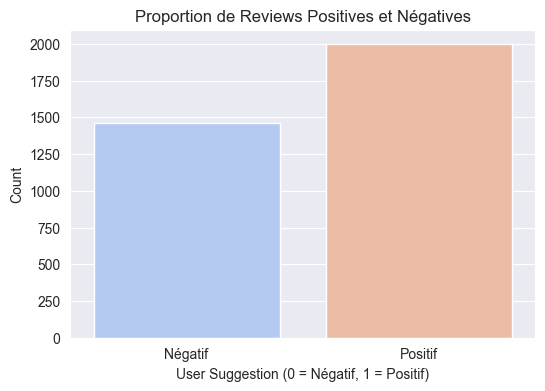

Nombre moyen de mots par commentaire : 112.54222093695778


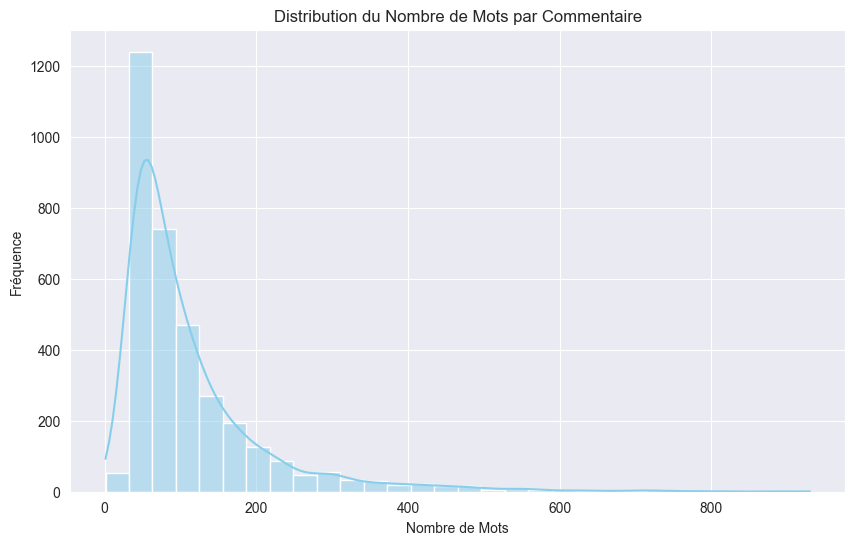

C:\Users\User\AppData\Local\Temp\ipykernel_8704\3472153579.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_games.index, y=top_games.values, palette='viridis')


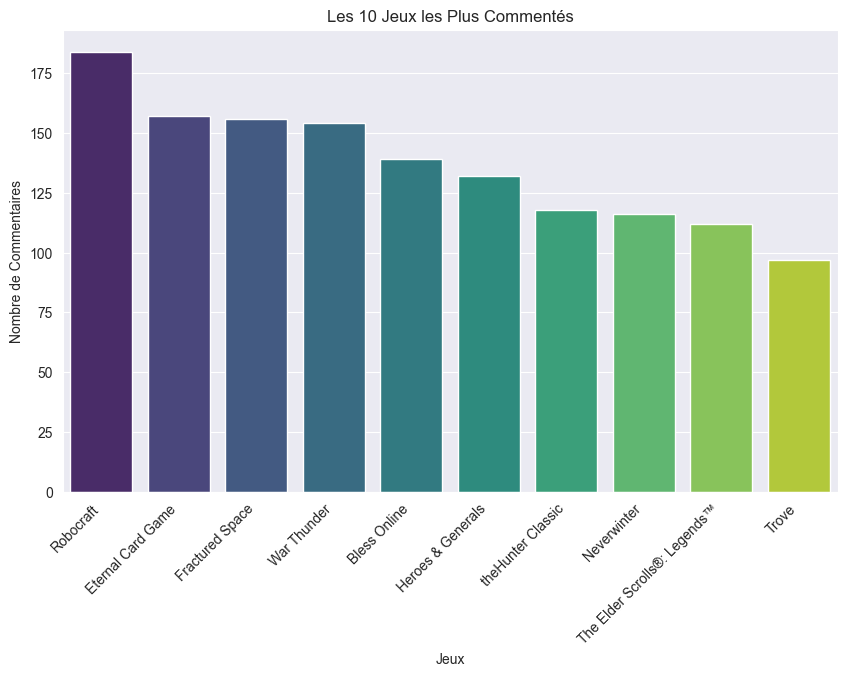

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Proportion de reviews positives et négatives
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='user_suggestion', palette='coolwarm')
plt.title('Proportion de Reviews Positives et Négatives')
plt.xlabel('User Suggestion (0 = Négatif, 1 = Positif)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Négatif', 'Positif'])
plt.show()

# 2. Nombre moyen de mots par commentaire
train_df['word_count'] = train_df['cleaned_review'].apply(lambda x: len(x.split()))

# Calcul du nombre moyen de mots
average_word_count = train_df['word_count'].mean()
print(f"Nombre moyen de mots par commentaire : {average_word_count}")

# Histogramme du nombre de mots par commentaire
plt.figure(figsize=(10, 6))
sns.histplot(train_df['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution du Nombre de Mots par Commentaire')
plt.xlabel('Nombre de Mots')
plt.ylabel('Fréquence')
plt.show()

# 3. Jeux les plus commentés
top_games = train_df['title'].value_counts().head(10)  # Les 10 jeux les plus commentés
plt.figure(figsize=(10, 6))
sns.barplot(x=top_games.index, y=top_games.values, palette='viridis')
plt.title('Les 10 Jeux les Plus Commentés')
plt.xlabel('Jeux')
plt.ylabel('Nombre de Commentaires')
plt.xticks(rotation=45, ha='right')
plt.show()

# Prétraitement exemple : Texte d'origine : "Les pommes sont rouges."

# Tokenization ( Diviser un texte en unités plus petites (tokens)) ["Les", "pommes", "sont", "rouges"]

In [5]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# Tokenisation des mots
train_df['tokens'] = train_df['cleaned_review'].apply(word_tokenize)

# Afficher un exemple
print(train_df['tokens'].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


2701     [old, review, ,, 2014, great, primarily, wwii,...
247      [early, access, reviewwow, ,, i, can, t, say, ...
9881     [i, read, a, few, of, the, reviews, and, hones...
2021     [stunning, visuals, ,, addictive, mechanics, ,...
12535    [game, ., cars, feel, like, driving, through, ...
Name: tokens, dtype: object


# Suppression des Stop Words (Enlever les mots fréquents et peu informatifs (ex. "le", "la", "de", "et", etc.)) ["pommes", "rouges"]

In [6]:
from nltk.corpus import stopwords

# Télécharger les stopwords
nltk.download('stopwords')

# Filtrer les tokens pour supprimer les stopwords
stop_words = set(stopwords.words('french'))  # Ou 'english' pour les données en anglais

train_df['tokens_no_stopwords'] = train_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Afficher un exemple
print(train_df['tokens_no_stopwords'].head())

2701     [old, review, ,, 2014, great, primarily, wwii,...
247      [early, access, reviewwow, ,, i, can, say, eno...
9881     [i, read, a, few, of, the, reviews, and, hones...
2021     [stunning, visuals, ,, addictive, mechanics, ,...
12535    [game, ., cars, feel, like, driving, through, ...
Name: tokens_no_stopwords, dtype: object


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Lemmatisation (Réduire les mots à leur forme canonique ou de base) ["pomme", "rouge"]

In [7]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatisation des tokens
train_df['tokens_lemmatized'] = train_df['tokens_no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Afficher un exemple
print(train_df['tokens_lemmatized'].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2701     [old, review, ,, 2014, great, primarily, wwii,...
247      [early, access, reviewwow, ,, i, can, say, eno...
9881     [i, read, a, few, of, the, review, and, honest...
2021     [stunning, visuals, ,, addictive, mechanic, ,,...
12535    [game, ., car, feel, like, driving, through, a...
Name: tokens_lemmatized, dtype: object


# Stemmatisation (Réduire les mots à leur racine)

In [8]:
from nltk.stem import PorterStemmer

# Initialisation du stemmer
stemmer = PorterStemmer()

# Stemmatisation des tokens
train_df['tokens_stemmed'] = train_df['tokens_no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

# Afficher un exemple
print(train_df['tokens_stemmed'].head())

2701     [old, review, ,, 2014, great, primarili, wwii,...
247      [earli, access, reviewwow, ,, i, can, say, eno...
9881     [i, read, a, few, of, the, review, and, honest...
2021     [stun, visual, ,, addict, mechan, ,, neat, fun...
12535    [game, ., car, feel, like, drive, through, a, ...
Name: tokens_stemmed, dtype: object


# Embeddings (Représentations vectorielles des mots)

In [9]:
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

# Charger le modèle pré-entraîné Word2Vec
model = api.load("word2vec-google-news-300")

# Initialiser le lemmatizer et la liste des stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Exemple de prétraitement et application des embeddings
def preprocess_and_embed(text):
    # Tokenisation
    tokens = word_tokenize(text.lower())

    # Suppression des stopwords
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    # Lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Générer les embeddings pour chaque token
    embeddings = [model[word] for word in tokens if word in model]

    # Retourner la moyenne des embeddings (ou toute autre opération que tu préfères)
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)  # Si aucun mot n'est dans le modèle, retourner un vecteur nul

# Appliquer la fonction à un texte
text = "The apples are red."
embedding = preprocess_and_embed(text)

print("Embedding moyen : ", embedding)

Embedding moyen :  [ 0.01635742 -0.12255859  0.1296997   0.17822266 -0.13879395 -0.00634766
  0.10498047 -0.2783203  -0.07910156  0.20654297 -0.00262451 -0.02423096
 -0.0524292  -0.0760498  -0.27392578  0.04052734 -0.17321777  0.15527344
 -0.19213867 -0.18579102 -0.12646484  0.20910645  0.1015625  -0.1465187
  0.00866699 -0.0100708  -0.11816406  0.11865234  0.15283203  0.09570312
  0.10107422  0.05743408  0.07568359  0.06323242 -0.03405762  0.03735352
  0.10717773 -0.22436523  0.07861328  0.14550781  0.05023193 -0.04656982
 -0.02453613 -0.11181641  0.13354492 -0.14355469  0.05004883 -0.10546875
  0.0168457   0.06645966 -0.20605469  0.13085938  0.09057617  0.02380371
 -0.08602905 -0.00280762 -0.0017395  -0.04693604 -0.06085205 -0.10583496
 -0.00341797 -0.04522705 -0.12939453 -0.07177734 -0.05131531  0.09182739
 -0.05708694 -0.15192413 -0.03049469  0.10913086  0.12142944  0.04443359
  0.1459961  -0.265625   -0.18310547  0.02864075  0.09643555  0.06799316
 -0.03881836  0.10595703 -0.05957

In [10]:
import tensorflow as tf
import sys
!{sys.executable} -m pip install scikit-learn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Paramètres du modèle

In [11]:
MAX_FEATURES = 5000  # Taille du vocabulaire
MAX_LENGTH = 100     # Longueur maximale des séquences
EMBEDDING_DIM = 128  # Dimension des embeddings

# Préparation des données pour le modèle

In [12]:
# Séparation en ensembles d'entraînement et de test
X = train_df['cleaned_review']
y = train_df['user_suggestion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenisation des textes
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Conversion des textes en séquences d'indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding pour avoir des séquences de longueur uniforme
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Création du modèle LSTM avec embeddings

In [13]:
model = Sequential([
    # Couche d'embeddings
    Embedding(input_dim=MAX_FEATURES+1, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),

    # Couches LSTM
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),

    # Couches denses pour la classification
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sortie binaire
])

# Compilation du modèle
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle
model.summary()

C:\Users\User\Code\reseaux_neuronaux\.venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Entraînement du modèle avec 13 époques

In [14]:
history = model.fit(
    X_train_pad, y_train,
    epochs=13,  # 13 époques comme demandé
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/13
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.5192 - loss: 0.6865 - val_accuracy: 0.5596 - val_loss: 0.6867
Epoch 2/13
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.5966 - loss: 0.6809 - val_accuracy: 0.6083 - val_loss: 0.6793
Epoch 3/13
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.6940 - loss: 0.6044 - val_accuracy: 0.5975 - val_loss: 0.6703
Epoch 4/13
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.7161 - loss: 0.5751 - val_accuracy: 0.5596 - val_loss: 0.6775
Epoch 5/13
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6070 - loss: 0.6747 - val_accuracy: 0.6083 - val_loss: 0.6738
Epoch 6/13
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.6163 - loss: 0.6686 - val_accuracy: 0.6191 - val_loss: 0.6712
Epoch 7/13
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.6304 - loss: 0.6598 - val_accuracy: 0.6209 - val_loss: 0.6578
Epoch 8/13
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.6693 - loss: 0.6383 - val_accu

# Évaluation du modèle

In [15]:
val_loss, val_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Prédictions
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Afficher le rapport de classification
print("Rapport de classification:")
print(classification_report(y_test, y_pred))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7212 - loss: 0.8578
Validation Loss: 0.9096547365188599
Validation Accuracy: 0.6994219422340393
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Rapport de classification:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       296
           1       0.74      0.73      0.74       396

    accuracy                           0.70       692
   macro avg       0.69      0.69      0.69       692
weighted avg       0.70      0.70      0.70       692



# Visualisation de la matrice de confusion

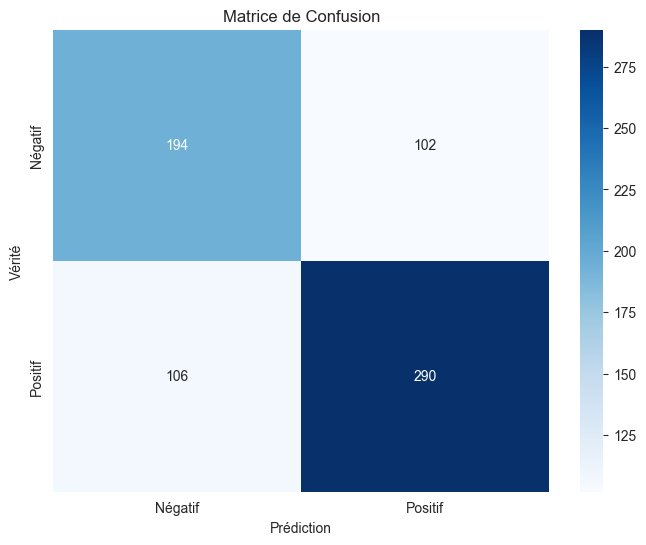

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de Confusion')
plt.show()

# Visualiser l'historique d'entraînement

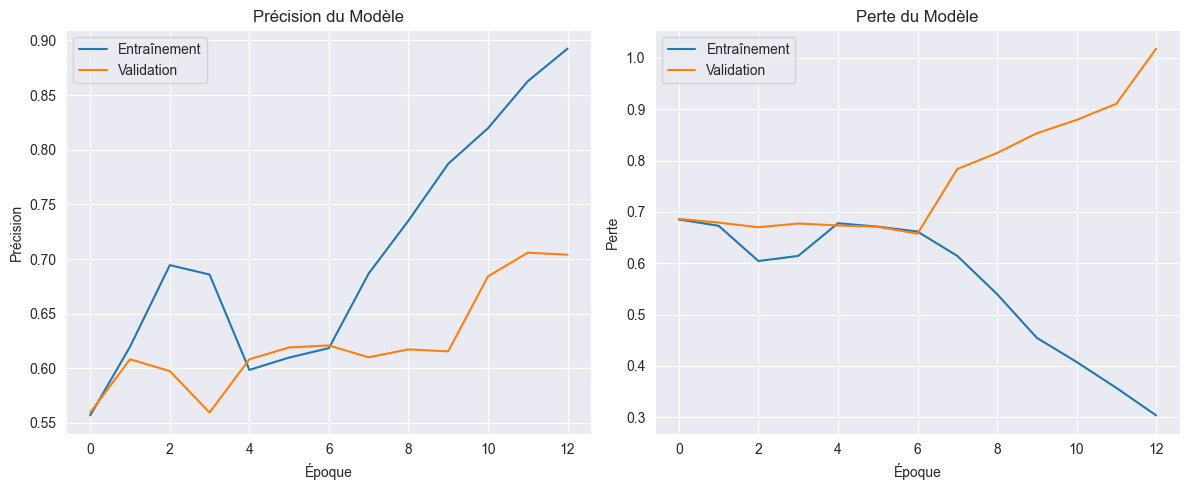

In [17]:
 plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du Modèle')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du Modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Sauvegarde du modèle

In [18]:
model.save('lstm_sentiment_model.h5')

# Sauvegarde du tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Modèle et tokenizer sauvegardés avec succès!")

Modèle et tokenizer sauvegardés avec succès!


# Chargement du modèle et prédictions

In [19]:
# Charger le modèle
loaded_model = load_model('lstm_sentiment_model.h5')

# Charger le tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

# Fonction pour faire des prédictions sur de nouveaux textes

In [20]:
def predict_sentiment(text, model, tokenizer):
    # Nettoyer le texte
    cleaned_text = clean_user_review(text)
    # Convertir en séquence
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    # Padding
    padded = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post', truncating='post')
    # Prédiction
    prediction = model.predict(padded)[0][0]
    sentiment = "Positif" if prediction > 0.5 else "Négatif"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return sentiment, confidence

# Exemples de prédictions
sample_reviews = [
    "This game is fantastic, I love the graphics and the gameplay.",
    "A real disappointment, not worth the price and full of bugs."
]

print("\nPrédictions sur de nouveaux avis:")
for review in sample_reviews:
    sentiment, confidence = predict_sentiment(review, loaded_model, loaded_tokenizer)
    print(f"Avis: {review}")
    print(f"Sentiment prédit: {sentiment} (confiance: {confidence:.2f})")
    print("-" * 50)


Prédictions sur de nouveaux avis:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Avis: This game is fantastic, I love the graphics and the gameplay.
Sentiment prédit: Positif (confiance: 0.85)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Avis: A real disappointment, not worth the price and full of bugs.
Sentiment prédit: Négatif (confiance: 0.60)
--------------------------------------------------
